# General informations

In [ ]:
## CHA-AIPH Project
# -*- coding: utf-8 -*-

"""
Created on Tue Jan 5 2021
@author: Tisseaux Antoine

This script is used to predict survival at hospital discharge for ICU patients
ML model used: RandomForest
"""

'\nCreated on Tue Jan 5 2021\n@author: Tisseaux Antoine\n\nThis script is used to predict survival at hospital discharge for ICU patients\nML model used: RandomForest\n'

# set environement

Importing packages

In [ ]:
# Importing libraries:
from joblib import dump, load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

Importing files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



loading csv files

In [ ]:
my_df_all_patients = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/my_df_survival_preprocess', sep=",")

setting options for pandas

In [ ]:
# Displaying option: all columns
pd.set_option('display.max_columns', None)

setting a random seed:

In [ ]:
# setting random seed
SEED = 25

# Creating train and test datasets:

In [ ]:
# creating a vector y with the outcome:
y = my_df_all_patients["hospital_death"]

# creating a dataset X with the variables used for the prediction
X = my_df_all_patients.drop('hospital_death', axis=1)

## splitting the data into train set and test set:

80% for training, 20% for testing : (test_size = 0.2)

we stratify on outcome

In [ ]:
# splitting scaled data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## vizualizing splitting:

train dataset:

In [ ]:
# training dataset size:
print("Nb of patients in training set is %i\n" % X_train.shape[0])
proportion_train = y_train.value_counts() / y_train.count()

# displaying number of patients with CKD and without CKD in the training set
print(f"Nb of patients dead at hospital discharge is {y_train.value_counts()[0]} "
      f"representing {proportion_train[0]} % of training dataset")
print(f"Nb of patients alive at hospital discharge is {y_train.value_counts()[1]} "
      f"representing {proportion_train[1]} % of training dataset\n")

Nb of patients in training set is 14878

Nb of patients dead at hospital discharge is 12580 representing 0.8455437558811668 % of training dataset
Nb of patients alive at hospital discharge is 2298 representing 0.15445624411883319 % of training dataset



test dataset:

In [ ]:
# test dataset size:
print("Nb of patients in test set is %i\n" % X_test.shape[0])
proportion_test = y_test.value_counts() / y_test.count()

# displaying number of patients with CKD and without CKD in the test set
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[0]} "
      f"representing {proportion_test[0]} % of test dataset")
print(f"Nb of patients dead at hospital discharge is {y_test.value_counts()[1]} "
      f"representing {proportion_test[1]} % of test dataset\n")

Nb of patients in test set is 3720

Nb of patients dead at hospital discharge is 3146 representing 0.8456989247311828 % of test dataset
Nb of patients dead at hospital discharge is 574 representing 0.1543010752688172 % of test dataset



# Tuning hyperparameters :

## Random Search Crossvalidation

possible hyperparameters:

In [ ]:
# giving the number of parameters for random forest, we can't use directly a cross validation search grid because
# it would take to much time. we need first a to do a cross validation randomized search to have an idea
# of the best parameters.

# possible hyperparameters for Random Forest:
#   # max_depth: maximum depth of the trees
#   # max_features: maximum features to consider at every split of the tree
#   # min_samples_split: minimum number of samples a node must have before it can be split
#   # min_samples_leaf: minimum number of samples a leaf node must have
#   # max_leaf_nodes : number of leaves at the end of the tree
#   # n_estimators: number of trees in the forest
#   # bootstrap: Whether samples are drawn with replacement

setting a range of hyperparameters to be tested

In [ ]:
# giving a research range for each parameter:
n_estimators = [5,10,20,50,100]
max_features = ['auto', 'log2', None]
max_depth = [1,2,5,10,20,50,100]
min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [SEED]}

running random grid search

In [ ]:
# We declare the random forest estimator:
rnd_clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores (n_jobs = -1)
rf_random = RandomizedSearchCV(estimator=rnd_clf, param_distributions=random_grid, scoring='f1',
                               n_iter=500, cv=5, random_state=SEED, n_jobs=-1, verbose=2)

# Fit the random search model:
rf_random.fit(X_train, y_train)

# returning the best parameters :
print(rf_random.best_params_)

# returning the best score :
print(rf_random.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'random_state': 25, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True}
0.3288144721222985


best result with random grid search:

In [ ]:
# 'random_state': 25, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True

## Grid search CrossValidation:



running grid search with random grid search estimation:

In [ ]:
# we can now use this first estimation of the best hyperparameters to build a cross validation search grid :

# Set all the combinaisons hyperpameters to be tested:
tuned_parameters = {'max_depth': [25, 30, 35, 40], 'max_features': ['log2'], 'min_samples_split': [2, 3],
                    'min_samples_leaf': [12, 13], 'n_estimators': [90, 100, 110], 'n_jobs': [-1],
                    'bootstrap': [False], 'random_state': [SEED]}


print("# Tuning hyper-parameters for f1-score")
print()

# Using GridSearchCV function to explore an estimator for multiple values of hyperameters
# We specify the estimator to use and all the hyperparameters in the variable 'tuned_parameters':
# GridSearchCV will compute a given score for each combinaison of hyperparameters
# We will compute for F1 score
rnd_clf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), tuned_parameters,
                            scoring='f1', n_jobs=-1, cv=5, verbose=2)

# we train the random forest estimators:
rnd_clf_grid.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()

# We print the best combinaison of hyperpameters founded
print(rnd_clf_grid.best_params_)
print()


print("Grid scores on development set:")
print()

# we will display the mean and the standard deviation of F1-score for
# all the combinaisons of hyperparameters tested with grid search:
means = rnd_clf_grid.cv_results_['mean_test_score']
stds = rnd_clf_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rnd_clf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()

y_true, rnd_y_pred = y_test, rnd_clf_grid.predict(X_test)
print(classification_report(y_true, rnd_y_pred))
print()

# Tuning hyper-parameters for f1-score

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters set found on development set:

{'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 110, 'n_jobs': -1, 'random_state': 25}

Grid scores on development set:

0.483 (+/-0.007) for {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 25}
0.483 (+/-0.007) for {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 25}
0.484 (+/-0.006) for {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 110, 'n_jobs': -1, 'random_state': 25}
0.483 (+/-0.007) for {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples

# building the best Random Forest model:

In [ ]:
# We declare the Random Forest estimator:
rnd_clf = rnd_clf_grid

# Performance evaluation:

## Confusion Matrix

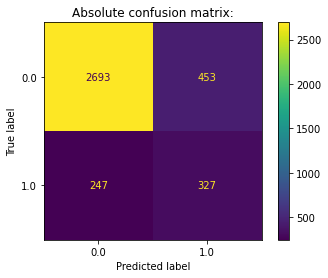

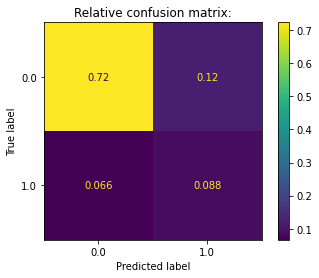

In [ ]:
# displaying absolute confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, rnd_y_pred, display_labels=rnd_clf.classes_)
plt.title("Absolute confusion matrix:")
plt.show()

# displaying relative confusion matrix:
disp = ConfusionMatrixDisplay.from_predictions(y_test, rnd_y_pred, display_labels=rnd_clf.classes_, normalize='all')
plt.title("Relative confusion matrix:")
plt.show()

## Performance scores

In [ ]:
# performance scores
print('accuracy score: %f\n' % accuracy_score(y_test, rnd_y_pred))
print('f1_score: %f\n' % f1_score(y_test, rnd_y_pred, average='weighted'))
print('recall score: %f\n' % recall_score(y_test, rnd_y_pred, average='weighted'))
print('precision score: %f\n' % precision_score(y_test, rnd_y_pred, average='weighted'))

accuracy score: 0.811828

f1_score: 0.822958

recall score: 0.811828

precision score: 0.839336



## ROC curve

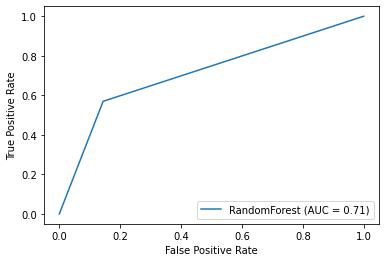


roc_auc score: 0.7128470199423635


In [ ]:
# displaying ROC curve:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rnd_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(tpr=tpr, fpr=fpr, roc_auc=roc_auc, estimator_name="RandomForest")
display.plot()
plt.show()

print('\nroc_auc score:', metrics.roc_auc_score(y_test, rnd_y_pred, average='weighted'))

## saving model:

In [ ]:
dump(rnd_clf, '/content/drive/MyDrive/CHAIPH_PROJECT_GR2/scripts/models/rnd_no_oversamp.joblib') 

['/content/drive/MyDrive/CHAIPH_PROJECT_GR2/scripts/models/rnd_no_oversamp.joblib']